In [72]:
import os
import math
import pickle
import pystan
from pystan import StanModel
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy import stats
import functools
from hashlib import md5
import pickle
import datetime
%matplotlib inline

start_time = "{0:%Y%m%d_%H%M%S}".format(datetime.datetime.now())

INPUT_PATH = "/mnt/c/Git/go/python/input/RStanBook/chap05/input/data-attendance-2.txt"
kk

# StanModelをいちいちコンパイルし直すのは面倒なので、こちらの関数で保存しロードする
def StanModel_cache(model_code, model_name=None, **kwargs):
    """Use just as you would `stan`"""
    # 公式の'ascii'ではうまくいかないので、'utf-8'に変更
#     code_hash = md5(model_code.encode('utf-8')).hexdigest()
    if model_name is None:
#         cache_fn = 'stan_pkl/cached-model-{}.pkl'.format(code_hash)
        cache_fn = '/mnt/c/Git/go/python/input/RStanBook/chap05/model/model-5-3.pkl'
    else:
        cache_fn = '/mnt/c/Git/go/python/input/RStanBook/chap05/model/{}-5-3.pkl'.format(model_name)

    try:
        sm = pickle.load(open(cache_fn, 'rb'))
    except: #tryで例外が発生すれば、smを書き込み
        sm = StanModel(file=model_code)
        with open(cache_fn, 'wb') as f:
            pickle.dump(sm, f)
    else: # tryで例外が発生しなければ、"Using cached StanModel"をプリント
        print("Using cached StanModel")
    return sm


data = pd.read_csv(INPUT_PATH, index_col='PersonID') # データセットを読み込む
data['ratio'] = data.Y / data.M
display(data.head())
display(data.describe())

,A,Score,M,Y,ratio
PersonID,,,,,
1,0,69,43,38,0.883721
2,1,145,56,40,0.714286
3,0,125,32,24,0.750000
4,1,86,45,33,0.733333
5,1,158,33,23,0.696970


,A,Score,M,Y,ratio
count,50.000000,50.000000,50.000000,50.00000,50.000000
mean,0.400000,121.700000,47.920000,34.44000,0.732199
std,0.494872,28.136874,17.953273,12.87643,0.123278
min,0.000000,51.000000,12.000000,10.00000,0.442857
25%,0.000000,105.250000,34.750000,26.00000,0.643681
50%,0.000000,120.500000,48.000000,33.50000,0.714286
75%,1.000000,142.500000,59.000000,43.00000,0.811298
max,1.000000,185.000000,88.000000,63.00000,0.983607


/mnt/c/Users/gixo/go/anaconda3/envs/stan_env/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


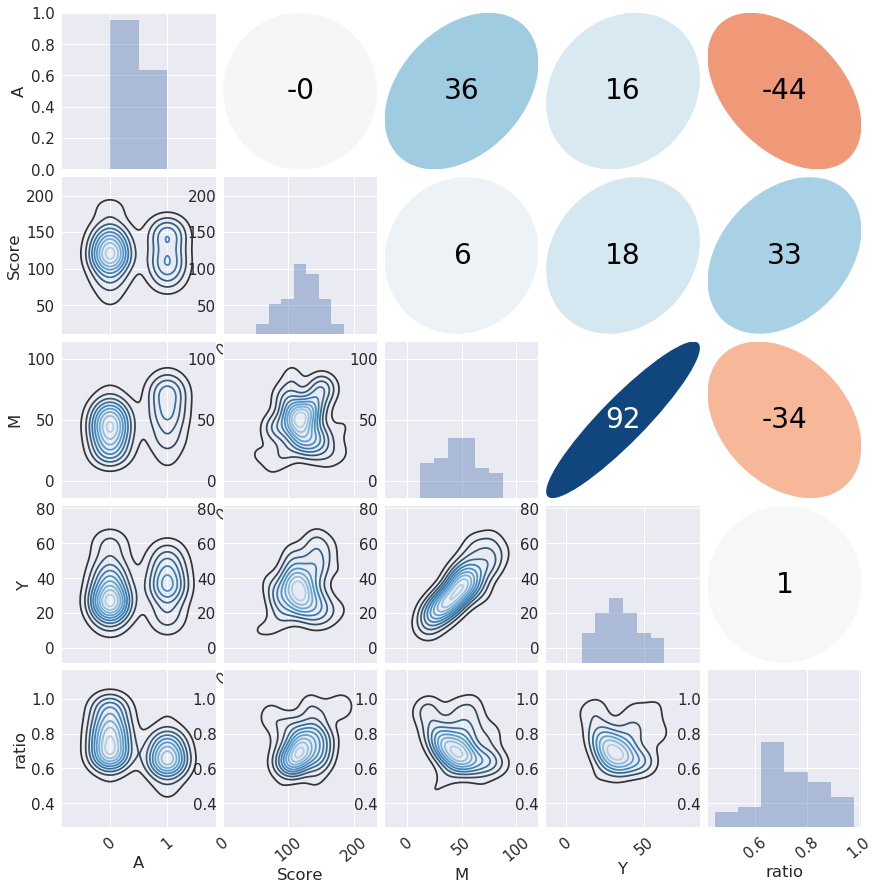

In [45]:
def corrfunc(x, y, **kws):
    r, _ = stats.spearmanr(x, y)
    ax = plt.gca()
    ax.axis('off')
    ellcolor = plt.cm.RdBu(0.5*(r+1))
    txtcolor = 'black' if math.fabs(r) < 0.5 else 'white'
    ax.add_artist(Ellipse(xy=[.5, .5], width=math.sqrt(1+r), height=math.sqrt(1-r), angle=45,
        facecolor=ellcolor, edgecolor='none', transform=ax.transAxes))
    ax.text(.5, .5, '{:.0f}'.format(r*100), color=txtcolor, fontsize=28,
        horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

sns.set(font_scale=1.5)
g = sns.PairGrid(data)
g = g.map_lower(sns.kdeplot, cmap='Blues_d')
g = g.map_diag(sns.distplot, kde=False)
g = g.map_upper(corrfunc)
g.fig.subplots_adjust(wspace=0.05, hspace=0.05)
for ax in g.axes.flatten():
    for t in ax.get_xticklabels():
        _ = t.set(rotation=40)

{'A': [0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'Score': [0.345, 0.725, 0.625, 0.43, 0.79, 0.665, 0.555, 0.735, 0.73, 0.725, 0.705, 0.685, 0.59, 0.555, 0.545, 0.495, 0.57, 0.41, 0.925, 0.78, 0.43, 0.54, 0.53, 0.715, 0.585, 0.64, 0.595, 0.595, 0.805, 0.565, 0.825, 0.37, 0.69, 0.62, 0.63, 0.655, 0.525, 0.55, 0.445, 0.44, 0.645, 0.665, 0.61, 0.74, 0.91, 0.525, 0.255, 0.75, 0.495, 0.495], 'M': [43, 56, 32, 45, 33, 61, 49, 76, 78, 64, 34, 44, 53, 40, 56, 59, 38, 45, 45, 77, 70, 77, 63, 68, 50, 51, 29, 37, 18, 49, 75, 12, 23, 37, 59, 55, 88, 47, 22, 41, 57, 32, 53, 31, 23, 51, 22, 38, 23, 67], 'Y': [38, 40, 24, 33, 23, 60, 35, 47, 63, 57, 18, 30, 33, 28, 46, 37, 27, 28, 43, 50, 31, 49, 38, 45, 37, 34, 21, 26, 17, 40, 58, 11, 18, 28, 39, 51, 55, 30, 18, 26, 46, 26, 36, 24, 22, 34, 10, 29, 20, 43], 'N': 50}


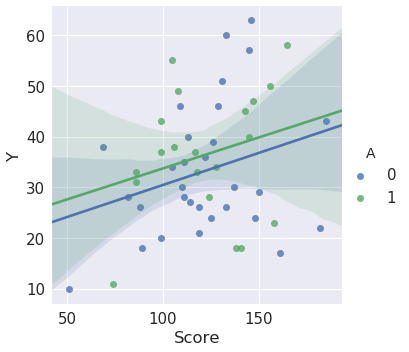

In [73]:
data.drop('ratio', axis=1, inplace=True)
stan_data = data.copy()
N = len(stan_data)
stan_data.Score /= 200 # スケーリングして説明変数の絶対値を揃える
stan_data = stan_data.to_dict('list')
stan_data.update({'N':N})
print(stan_data)

# とりあえずデータを見てみる
sns.lmplot(x='Score', y='Y', hue='A', data=data)

In [74]:
# モデルのコンパイル＆保存（StanModel関数を直実行でもよし）
model = StanModel_cache(model_code=STAN_PATH)

# 保存したコンパイル済みのモデルを取り出す
# with open('stan_pkl/cached-model-ccb3e87a1dc34687fa0d76c8a1bdd683.pkl', 'rb') as f:
#     model = pickle.load(f) 

# MCMCサンプリング NUTS   
fit_nuts = model.sampling(data = stan_data, seed=1234, warmup=1000, chains=4)

# サンプリング結果を保存（なくても大丈夫）
# with open('stan_pkl/fit5-3_20171130.pkl', 'wb') as f:
#     pickle.dump(fit_nuts, f)

#MCMCサンプリング結果の抽出（トレースプロットを見るので全て抽出）
ms = fit_nuts.extract(permuted=False, inc_warmup=True)

#ウォームアップ（バーンイン）のサイズを取得
iter_from = fit_nuts.sim['warmup']

#ウォームアップを省いた区間の配列
iter_range = np.arange(iter_from, ms.shape[0])

#トレースプット描画の時はこちらを使う
iter_start = np.arange(0, ms.shape[0])

#各変数名を取得
paraname = fit_nuts.sim['fnames_oi']

Using cached StanModel


/mnt/c/Users/gixo/go/anaconda3/envs/stan_env/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
  app.launch_new_instance()


In [75]:
print(fit_nuts)

Inference for Stan model: anon_model_004c106b40e5e7fb5b70c573034b1234.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  6.1e-3   0.22  -0.36  -0.06   0.09   0.24   0.53   1323    1.0
b2          -0.62  2.3e-3    0.1  -0.81  -0.69  -0.62  -0.56  -0.44   1799    1.0
b3           1.91  9.9e-3   0.36   1.19   1.67   1.91   2.15   2.62   1327    1.0
q[0]         0.68  6.4e-4   0.02   0.63   0.66   0.68   0.69   0.72   1435    1.0
q[1]          0.7  3.4e-4   0.02   0.67   0.69    0.7   0.71   0.73   2220    1.0
q[2]         0.78  2.4e-4   0.01   0.76   0.77   0.78   0.79   0.81   2271    1.0
q[3]         0.57  5.3e-4   0.02   0.53   0.56   0.57   0.59   0.62   1824    1.0
q[4]         0.73  4.1e-4   0.02   0.69   0.71   0.73   0.74   0.76   1920    1.0
q[5]          0.8  2.5e-4   0.01   0.77   0.79    0.8    0.8   0.82   223

Text(0,0.5,'Predicted')

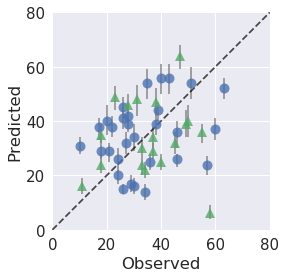

In [81]:
# warmupを含まない通常のサンプリングデータ抽出
ms_n = fit_nuts.extract()
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]

# percentileの行方向指定で、各学生の10%、50%, 90%の値を取得。それを行ベクトルから列ベクトルに変換
df_qua = pd.DataFrame(np.percentile(ms_n['y_pred'], q = quantile, axis=0).T, columns=colname)
d = pd.concat([data, df_qua], axis=1)
d0 = d[d.A == 0]
d1 = d[d.A == 1]

palette = sns.color_palette()
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot([0, 80], [0, 80], 'k--', alpha=0.7)
ax.errorbar(d0.Y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
           fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.Y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
           fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')